In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras
from sklearn.model_selection import train_test_split as train_valid_split
import numpy as np
from keras.models import load_model
# plt.style.use('dark_background') # incase you are using jupyter dark theme, comment otherwise
np.random.seed(1)

In [0]:
# usefull classes
class PlotLearning(keras.callbacks.Callback):
    """
    Inherits the Callback class
    A class inheriting Callback is expected to have the methods on_train_begin and,
    on_epoch_end. These methods are called in the backend.
    """
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16, 8))
        
        clear_output(wait=True)
        
        # loss plot
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.set_xlabel("epochs")
        ax1.set_ylabel("loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="acc")
        ax2.plot(self.x, self.val_acc, label="val_acc")
        ax1.set_xlabel("epochs")
        ax1.set_ylabel("loss")
        ax2.legend()
        
        plt.show()
        
        
class CustomEarlyStop(keras.callbacks.Callback):
    """
    Inherits the Callback class
    A class inheriting Callback is expected to have the methods on_train_begin and,
    on_epoch_end. These methods are called in the backend.
    """
    def __init__(self, monitor='val_acc', value=0.9900):
        self.monitor = monitor
        self.value = value

    def on_epoch_end(self, epoch, logs={}):
        
        curr_value = logs.get(self.monitor)
        
        if curr_value >= self.value:
            print(f"Congratulations! You reached the target {self.monitor} of {self.value}")
            self.model.stop_training = True

In [0]:
# load the dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_valid, y_train, y_valid  = train_valid_split(x_train, y_train, 
                                                        train_size=0.9, shuffle=True, 
                                                        random_state=42)

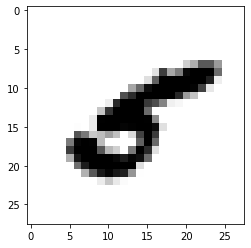

In [26]:
# show a random image from the training set
plt.imshow(x_train[np.random.randint(0, x_train.shape[0]), :, :], cmap="gray_r")

In [0]:
# normalize the data
x_train, x_test, x_valid = x_train/255.0, x_test/255.0, x_valid/255.0

In [0]:
def generate_model_base():
    """
    returns: a model object desccribed below
    """
    return keras.models.Sequential([
        keras.layers.Reshape(target_shape=(28, 28, 1)),
       
        # TODO: modify this function
        keras.layers.Conv2D(kernel_size=3, filters=12,activation='relu', padding='valid'),
        #keras.layers.BatchNormalization(center=True, scale=False),
        keras.layers.Dropout(.25),
        
    
        keras.layers.Conv2D(kernel_size=3, filters=24, activation='relu', padding='valid',strides=2),
        #keras.layers.BatchNormalization(center=True, scale=False),
        #keras.layers.Activation('relu'),
        keras.layers.Dropout(.25),
    
        keras.layers.Conv2D(kernel_size=3, filters=32, activation='relu', padding='valid', strides=2),
        #keras.layers.BatchNormalization(center=True, scale=False),
        #keras.layers.Activation('relu'),
        keras.layers.Dropout(.25),
        
        
        keras.layers.Flatten(),
        keras.layers.Dense(200, activation='relu'),
        #keras.layers.BatchNormalization(center=True, scale=False),
        #keras.layers.Activation('relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

def compile_model(m):
    """
    compile model with specific optimizer and loss funtion
    m: model object
    """
    m.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss='categorical_crossentropy', # expects targets to be hot-encoded
        metrics=['accuracy']
    )
    return m

In [0]:
keras.backend.clear_session() # do this everytime before creating a new model
model = generate_model_base()
model = compile_model(model)

In [30]:
# write the YAML config of the above model to a file
open('mnist_cnn_model.yaml', 'w').write(model.to_yaml())
#print(model.to_yaml())

3882

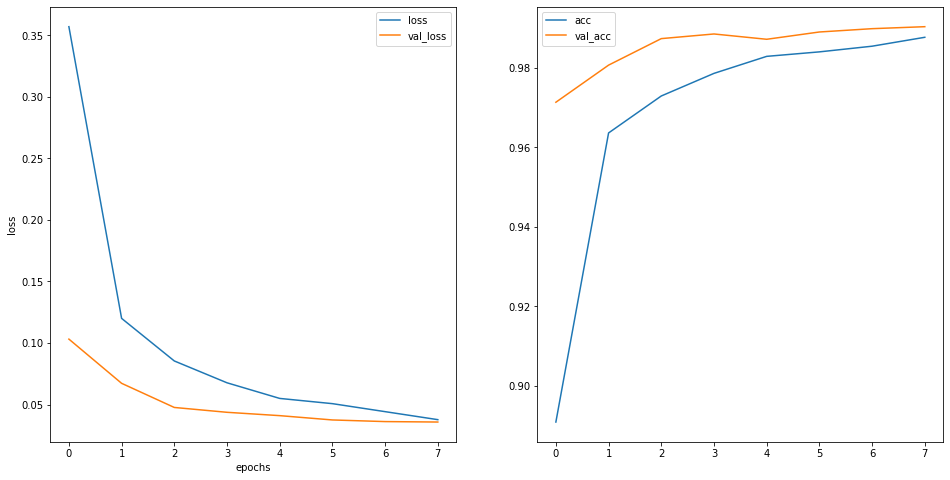

Congratulations! You reached the target val_acc of 0.99


In [31]:
hist = model.fit(
    x_train, keras.utils.to_categorical(y_train),
    validation_data=(x_valid, keras.utils.to_categorical(y_valid)),
    epochs=200,
    verbose=1,
    batch_size=128,
    callbacks=[PlotLearning(), CustomEarlyStop()]
)

In [32]:
model.build(input_shape=(None,28,28,1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 24)        2616      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          6944      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)         

In [33]:
# evaluate model
metrics = model.evaluate(x_test, keras.utils.to_categorical(y_test), verbose=0)
print(f'loss: {metrics[0]:.2f}, accuracy: {metrics[1] * 100:.2f}')

loss: 0.03, accuracy: 98.93


In [0]:
# save model
model.save('mnist_digits_base.h5')

In [0]:
# use this block of code to download h5 and tflite and tflite quant files from google colab to your local machine
# NOTE: YOU WILL NEED TO USE GOOGLE CHROME TO USE THIS FEATURE
# YOU WILL NEED TO ENABLE 3RD PARTY COOKIES FROM GOOGLE COLAB
# HERE ARE THE INSTRUCTIONS FOR THAT: https://stackoverflow.com/questions/53581023/google-colab-file-download-failed-to-fetch-error
# YOU NEED TO CLOSE THIS BROWSER AND REOPEN FOR THE CHANGE TO TAKE EFFECT
# YOU MAY NEED TO RUN THIS CELL TWO TIMES FOR IT TO WORK
from google.colab import files
files.download('mnist_digits_base.h5') #  